In [1]:
# import useful modual
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import plot, show
import re
from scipy.cluster.vq import kmeans, vq
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load the data and drop the lines with too many fields or no dataframe will be returned
df = pd.read_csv('books.csv', error_bad_lines = False) 
df.head()

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964


In [3]:
# explore data
df.shape

(13714, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              13714 non-null  int64  
 1   title               13714 non-null  object 
 2   authors             13714 non-null  object 
 3   average_rating      13714 non-null  float64
 4   isbn                13714 non-null  object 
 5   isbn13              13714 non-null  int64  
 6   language_code       13714 non-null  object 
 7   # num_pages         13714 non-null  int64  
 8   ratings_count       13714 non-null  int64  
 9   text_reviews_count  13714 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 1.0+ MB


In [5]:
df.describe()

,bookID,average_rating,isbn13,# num_pages,ratings_count,text_reviews_count
count,13714.000000,13714.000000,1.371400e+04,13714.000000,1.371400e+04,13714.000000
mean,22159.859195,3.930620,9.764017e+12,342.402727,1.776540e+04,533.632128
std,13700.926816,0.357893,3.987679e+11,252.650165,1.129572e+05,2529.006691
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10619.250000,3.770000,9.780345e+12,196.000000,8.300000e+01,7.000000
50%,21321.500000,3.960000,9.780613e+12,301.000000,6.305000e+02,40.000000
75%,33311.750000,4.130000,9.780940e+12,421.000000,4.742250e+03,222.000000
max,47709.000000,5.000000,9.790008e+12,6576.000000,5.629932e+06,93619.000000


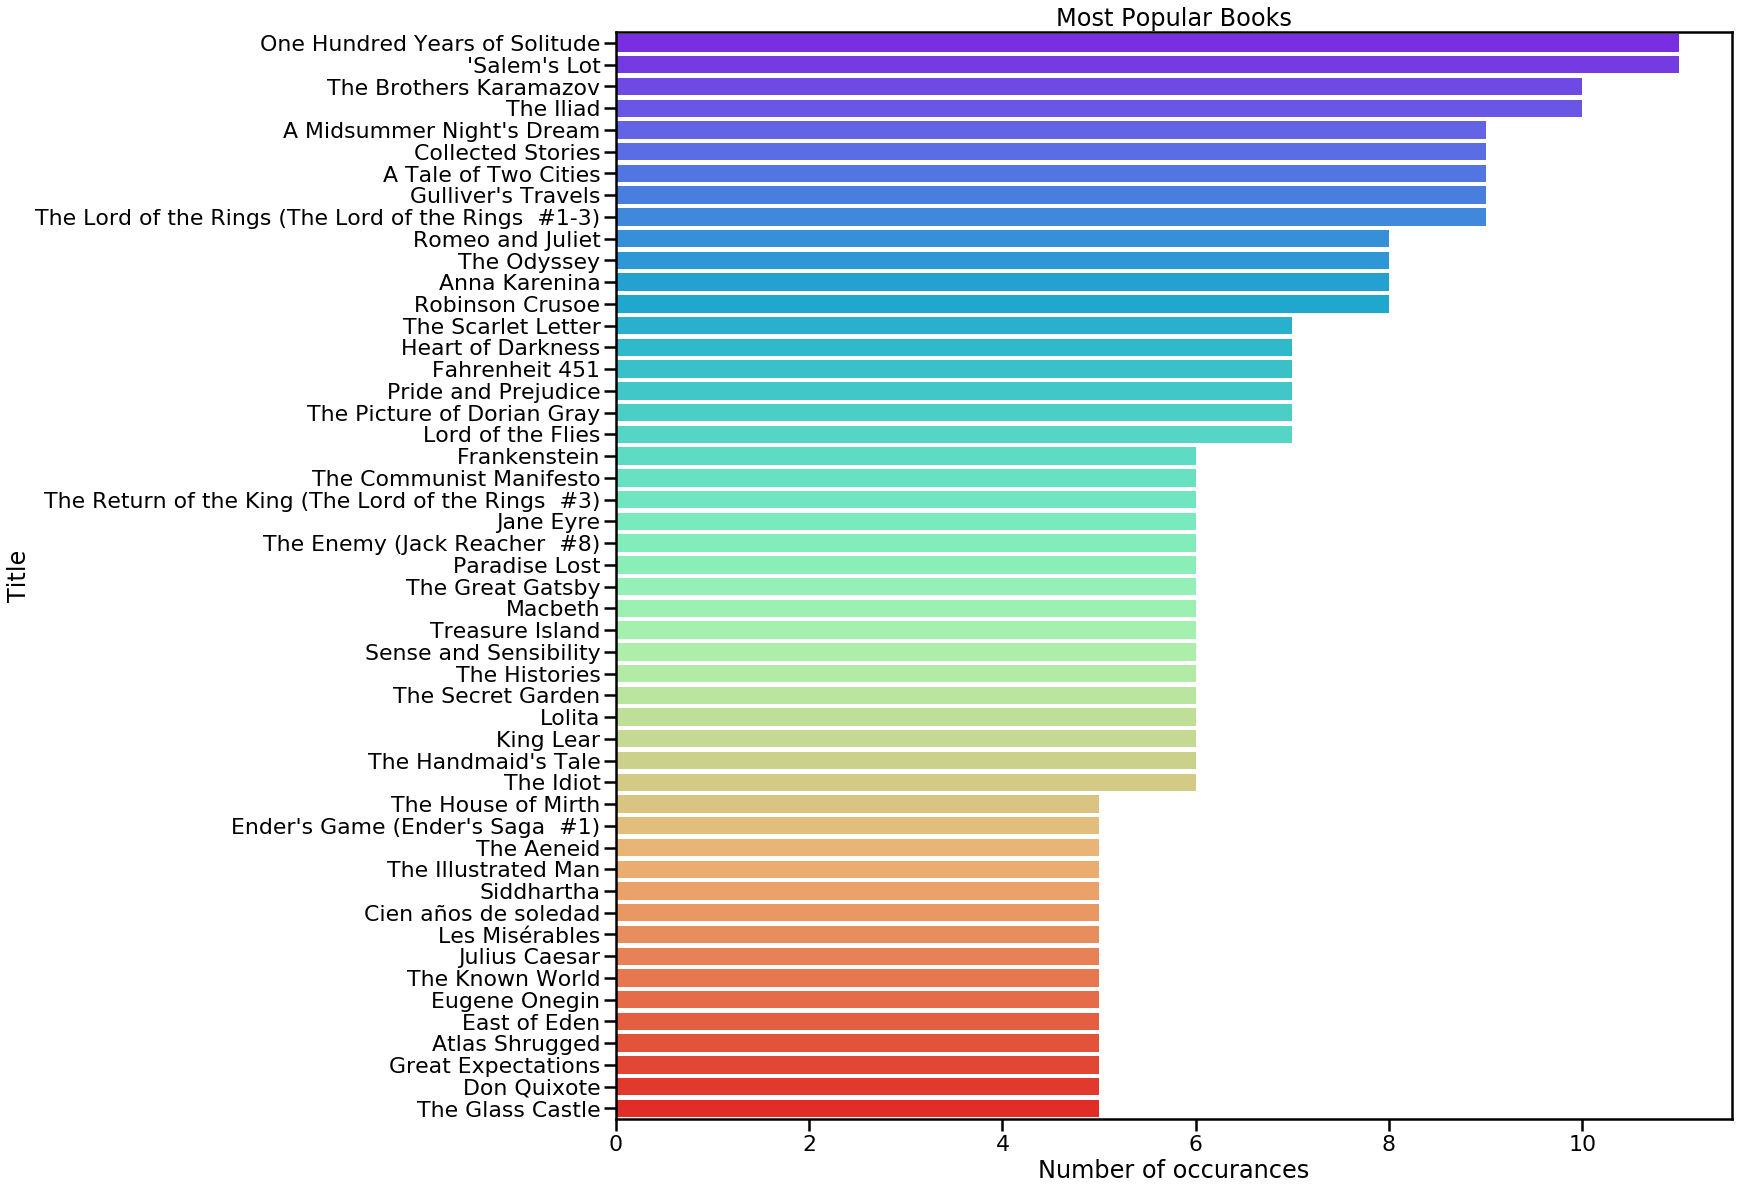

In [6]:
# visualize the top 50 popular books with the most number of editions among publishers
sns.set_context('poster')
plt.figure(figsize=(20,20))
books_50 = df['title'].value_counts()[:50]
top50_rating = df.average_rating[:50]
sns.barplot(x = books_50, y = books_50.index, palette='rainbow')
plt.title("Most Popular Books")
plt.xlabel("Number of occurances")
plt.ylabel("Title")
plt.show()

We can see from the above bar chart, the book "One Hundred Years of Solitude" and "Salem's Lot" own the most editions by several publishers. This may due to that these books are aged and also they are the most valuable in literature industry.

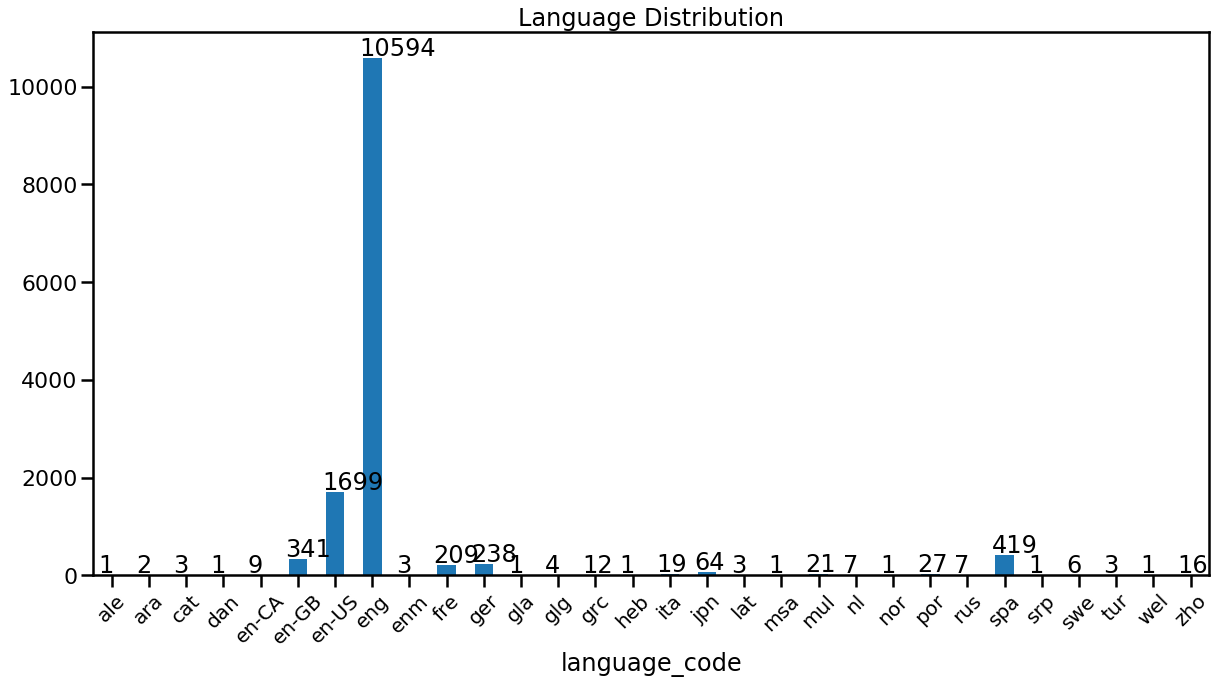

In [7]:
# visulize the distribution of languages of books
plt.figure(figsize=(20,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Distribution')
plt.xticks(fontsize = 20, rotation=45)

# annotate the number counts of each language on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.1, p.get_height()+50))

As we see from the above visualization, Engish is the majority languages in books. Also, the second and forth languages are also English but in different countries.

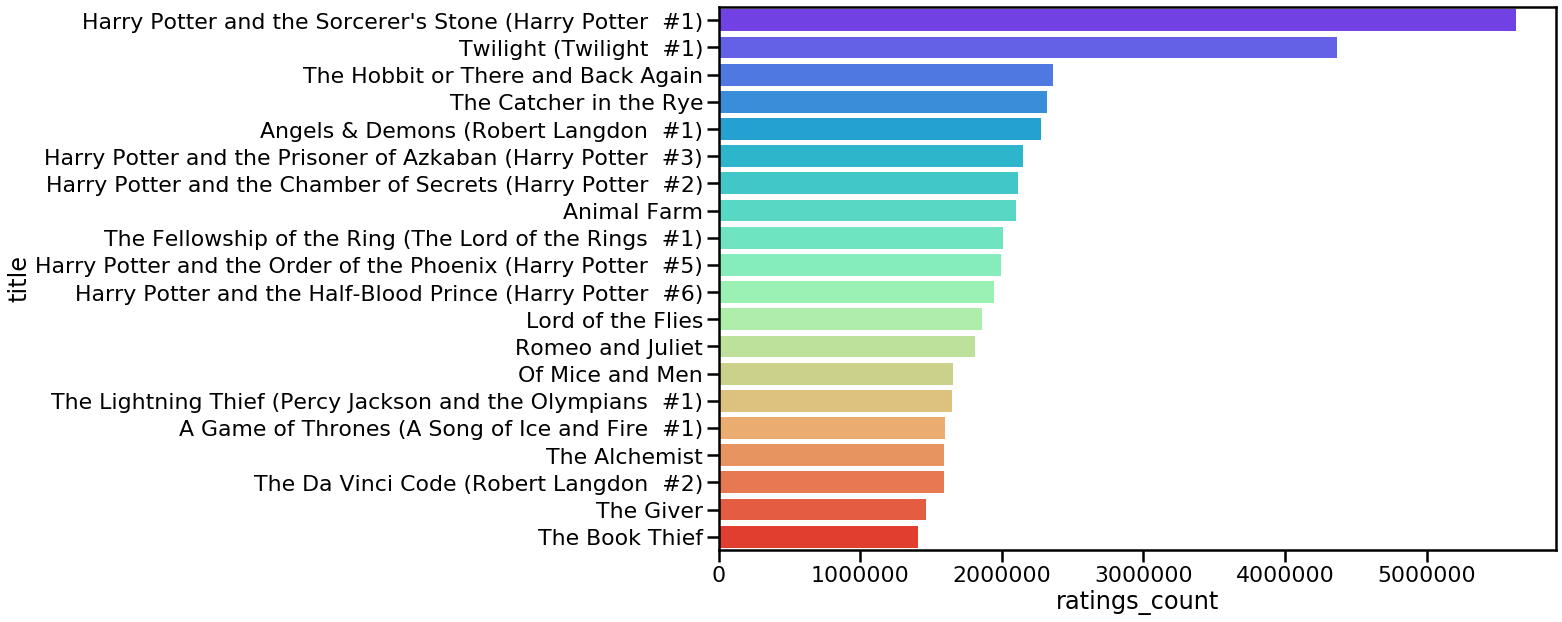

In [8]:
# get the top 20 ranking of the books
rated_20 = df.sort_values('ratings_count', ascending = False)[:20].set_index('title')
plt.figure(figsize=(15,10))

# for the counts are large, thus using horizaontal bar plot is a better choice than a regular bar plot
sns.barplot(rated_20['ratings_count'], rated_20.index, palette='rainbow')

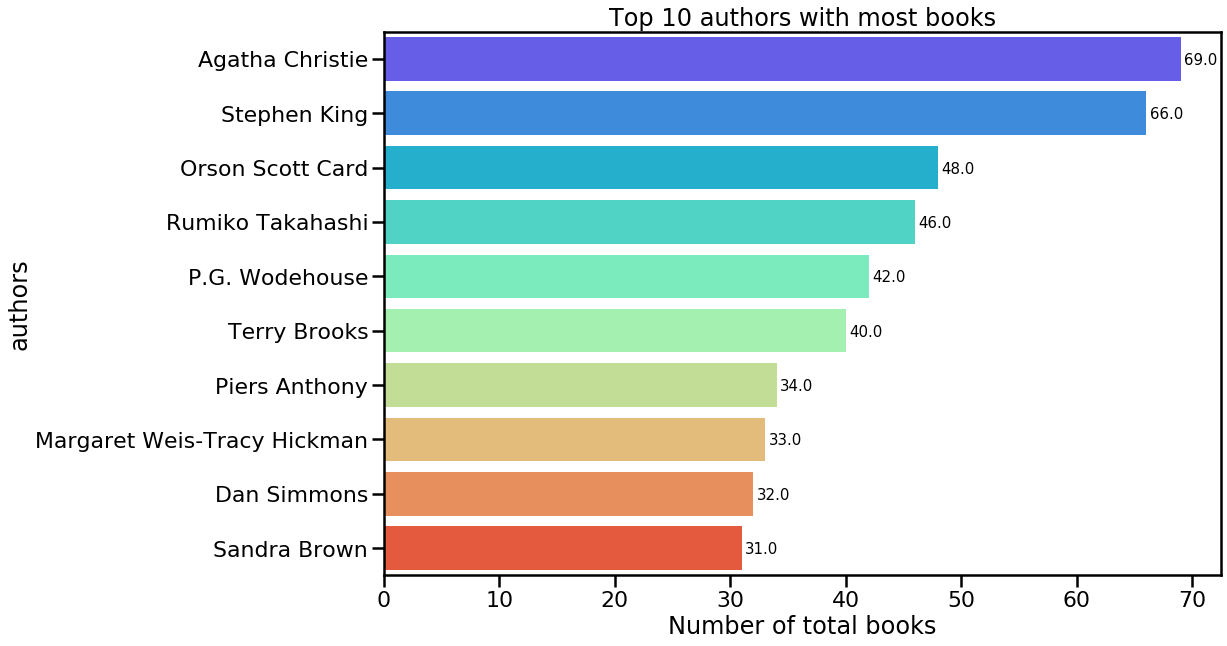

In [9]:
# get the autohors with most books in the list
authors_most_books = df.groupby('authors')['title'].count()\
                    .reset_index()\
                    .sort_values('title', ascending=False)\
                    .head(10)\
                    .set_index('authors')

plt.figure(figsize=(15,10))
ax = sns.barplot(authors_most_books['title'], authors_most_books.index, palette='rainbow')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Number of total books")

# add lables on each author
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 15)

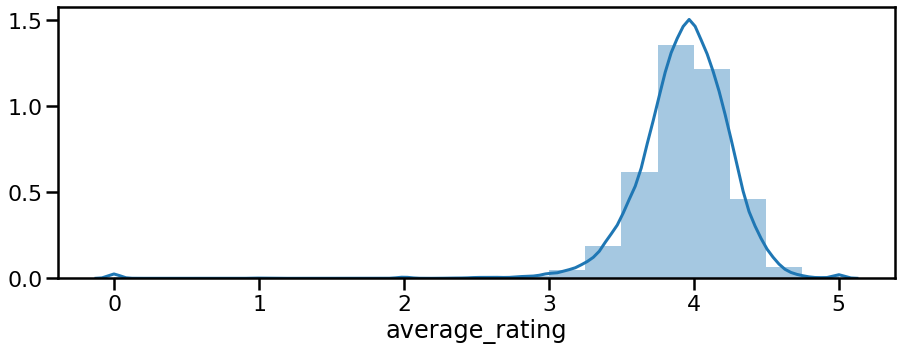

In [10]:
# visualize the distribution of ratings on books
plt.figure(figsize=(15,5))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)

As we see from the above plot, it has a extreme left skewed, meaning that most of the books were rated high scores and the difference of maximum and minimum is huge. And books been rated 5 is rarely seen.

In [11]:
# KMeans clustering

features = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(features['average_rating']), np.asarray(features['ratings_count'])]).T

In [12]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

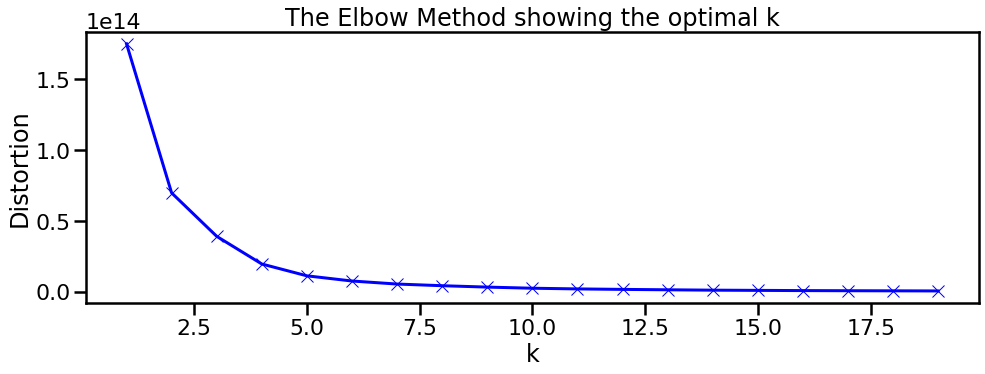

In [13]:
plt.figure(figsize=(16,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the above plot, we can see that the elbow located around the value K=3, so that's what we will use clusters number for it.


In [14]:
# compute K means with K = 3
centroids, _ = kmeans(data, 3)

#assign each sample to a cluster


idx, _ = vq(data, centroids) #Vector Quantisation

In [15]:
c = pd.DataFrame(idx)
c.describe()

,0
count,13714.000000
mean,0.954062
std,0.234652
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


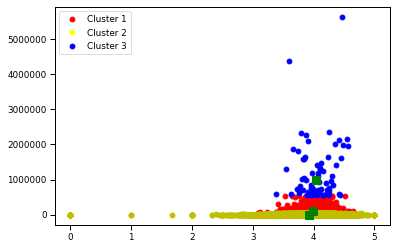

In [16]:
# plot the data using numpy's logical indexing
sns.set_context('paper')

#plt.figure(figsize=(10,5))
plt.plot(data[idx==0,0],data[idx==0,1],'or',
         data[idx==1,0],data[idx==1,1],'oy',
         data[idx==2,0],data[idx==2,1],'ob')

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8)

# add legent to the left of the plot
circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'yellow', linewidth = 0,marker= 'o', markerfacecolor='yellow')
circle3 = Line2D(range(1), range(1), color = 'blue',linewidth=0,  marker= 'o', markerfacecolor='blue')
plt.legend((circle1, circle2, circle3)
           , ('Cluster 1','Cluster 2', 'Cluster 3'), numpoints = 1, loc = 0, )


plt.show()

We can see from the above plot, it is a left skewed, thus we would need to remove some outliers.

In [17]:
features.idxmax(axis = 0, skipna=True)

average_rating    705
ratings_count       2
dtype: int64

In [18]:
features.drop(3, inplace = True)
features.drop(2034, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
data2 = np.asarray([np.asarray(features['average_rating']), np.asarray(features['ratings_count'])]).T

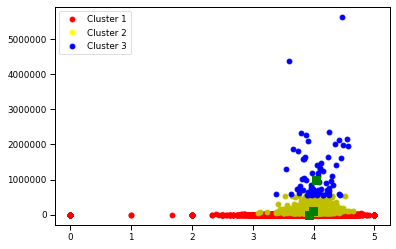

In [20]:
# compute K means with K = 3
centroids, _ = kmeans(data2, 3)

#assign each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data2, centroids)

# plot the data using numpy's logical indexing
sns.set_context('paper')

#plt.figure(figsize=(10,5))
plt.plot(data2[idx==0,0],data2[idx==0,1],'or',
         data2[idx==1,0],data2[idx==1,1],'oy',
         data2[idx==2,0],data2[idx==2,1],'ob')

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8)

# add legend on the left of plot
circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'yellow', linewidth = 0,marker= 'o', markerfacecolor='yellow')
circle3 = Line2D(range(1), range(1), color = 'blue',linewidth=0,  marker= 'o', markerfacecolor='blue')
plt.legend((circle1, circle2, circle3)
           , ('Cluster 1','Cluster 2', 'Cluster 3'), numpoints = 1, loc = 0, )


plt.show()

In [21]:
def range_on_ratings(df):
    
    # add a new column which segregate ratings to differnet range
    rate = []
    
    for val in df.average_rating:
        if val>=0 and val<=1:
            rate.append("Between 0 & 1")
        elif val>1 and val<=2:
            rate.append("Between 1 & 2")
        elif val>2 and val<=3:
            rate.append("Between 2 & 3")
        elif val>3 and val<=4:
            rate.append("Between 3 & 4")
        elif val>4 and val<=5:
            rate.append("Between 4 & 5")
        else:
            rate.append("NaN")
    
    return rate

df['Ratings_range'] = range_on_ratings(df)


In [22]:
# transform categorical features into dummy variables to scale it then apply to Kmeans analysis
used_features = pd.concat([df['Ratings_range'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)
used_features

,Between 0 & 1,Between 1 & 2,Between 2 & 3,Between 3 & 4,Between 4 & 5,average_rating,ratings_count
0,0,0,0,0,1,4.56,1944099
1,0,0,0,0,1,4.49,1996446
2,0,0,0,0,1,4.47,5629932
3,0,0,0,0,1,4.41,6267
4,0,0,0,0,1,4.55,2149872
...,...,...,...,...,...,...,...
13709,0,0,0,1,0,3.82,11317
13710,0,0,0,1,0,3.72,8710
13711,0,0,0,1,0,3.53,14334
13712,0,0,0,0,1,4.43,1550


In [23]:
# reduce the bias of these features to perform analysis
min_max_scaler = MinMaxScaler()
used_features = min_max_scaler.fit_transform(used_features)

# print the equalized results
used_features

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 9.12000000e-01, 3.45314828e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.98000000e-01, 3.54612809e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.94000000e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.06000000e-01, 2.54603430e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.86000000e-01, 2.75314160e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 8.58000000e-01, 6.34465923e-04]])

In [24]:
model1 = neighbors.NearestNeighbors(n_neighbors=3, algorithm='auto')
model1.fit(used_features)

# unpack index so that it can be used in later to search for similar books based on index
distance, index = model1.kneighbors(used_features)

In [25]:
# take one of my favorite book for analysis: "Walden" by Thoreou
df[df["title"]=='Walden'].index.tolist()[0]

5683

Useful function to get the index of books or authors

In [26]:
def get_index_author(name):
    return df[df["authors"]==name].index.tolist()[0]


In [27]:
get_index_author('V.T. Rajshekar-Y.N. Kly')

107

In [28]:
def get_index_book(name):
    return df[df["title"]==name].index.tolist()[0]

In [29]:
all_authors = list(df.authors.values)
all_authors

['J.K. Rowling-Mary GrandPré',
 'J.K. Rowling-Mary GrandPré',
 'J.K. Rowling-Mary GrandPré',
 'J.K. Rowling',
 'J.K. Rowling-Mary GrandPré',
 'J.K. Rowling-Mary GrandPré',
 'W. Frederick Zimmerman',
 'J.K. Rowling',
 'Douglas Adams',
 'Douglas Adams',
 'Douglas Adams',
 'Douglas Adams-Stephen Fry',
 'Douglas Adams',
 'Bill Bryson-William Roberts',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'Bill Bryson',
 'J.R.R. Tolkien',
 'J.R.R. Tolkien',
 'J.R.R. Tolkien',
 'J.R.R. Tolkien',
 'J.R.R. Tolkien-Alan  Lee',
 'Chris   Smith-Christopher  Lee-Richard Taylor',
 'Jude Fisher',
 'J.R.R. Tolkien',
 'James Hamilton-Paterson',
 'Dave Thomas-David Heinemeier Hansson-Leon Breedt-Mike Clark-Thomas  Fuchs-Andreas  Schwarz',
 'Gary Paulsen',
 'Donna Ickes-Edward Sciranko-Keith Vasconcelles',
 'Gary Paulsen',
 'Molly Hatchet',
 'Dale Peck',
 'Angela Knight-Sahara Kelly-Judy Mays-Marteeka Karland-Kate Douglas-Shelby Morgen-Lacey Sav

In [30]:
all_books = list(df.title.values)
all_books

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)',
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter  #1)",
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5)',
 'Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation',
 'Harry Potter Collection (Harry Potter  #1-6)',
 "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy  #1-5)",
 "The Ultimate Hitchhiker's Guide to the Galaxy",
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy  #1)",
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy  #1)",
 "The Ultimate Hitchhiker's Guide (Hitchhiker's Guide to the Galaxy #1-5)",
 'A Short History of Nearly Everything',
 "Bill Bryson's African Diary",
 "Bryson's Di

It is useful and more practical to only look up of books and authors by just type in their partial name.

In [31]:
def find_author_info(partial_name):
    for name in all_authors:
            if partial_name in name:
                print(name,all_authors.index(name))

In [32]:
def find_book_info(partial_title):
    for name in all_books:
            if partial_title in name:
                print(name,all_books.index(name))

Use one of my favorite book for the test of function : Walden by Thoreau

In [33]:
find_book_info('Walden')

Walden & Resistance to Civil Government (Critical Edition) 5678
Walden 5683


In [34]:
find_author_info('Thoreau')

Owen  Thomas-William John Rossi-Henry David Thoreau-William Rossi 5678
Henry David Thoreau-Elizabeth Hall Witherell 5679
Henry David Thoreau-Carl Bode 5680
Henry David Thoreau-Barry M. Andrews 5681
Henry David Thoreau 5682
Henry David Thoreau 5682


Get the similar of the objects we are looking for by using the kneighbors created above, using its nearest center to find out the similar items to it.

In [35]:
def similar_books(keyword=None,id=None):
    if id:
        for id in index[id][1:]:
            print(df.iloc[id]["title"])
            
    if keyword:
        search_id = get_index_book(keyword)
        for id in index[search_id][1:]:
            print(df.iloc[id]["title"])

Test if the above function works:

In [36]:
df[df["title"]=='Walden'].index.tolist()[0]

5683

In [37]:
# find similar books to Walden based on its popularity and ratings
similar_books(id=5683)

Xenocide (Ender's Saga  #3)
The Corrections


In [38]:
similar_books(keyword="Walden")

Xenocide (Ender's Saga  #3)
The Corrections


We can see from the above the two ways to find out similar books to Walden has the same results.